<a href="https://colab.research.google.com/github/csabiu/Astrostatistics/blob/main/GAIA_cross_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install astroquery

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.2/910.2 kB 13.7 MB/s eta 0:00:00


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import (SkyCoord, Distance, Galactic,
                                 EarthLocation, AltAz)
import astropy.coordinates as coord
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import AltAz
from astropy.io import fits
from astropy.table import QTable
from astropy.utils.data import download_file
from astroquery.gaia import Gaia



GACS is operational after the datacentre migration but DataLink is not yet fully operational


In [3]:
job = Gaia.launch_job_async("SELECT TOP 10000 gaia.parallax, gaia.source_id,gaia.ref_epoch,gaia.ra,gaia.dec,gaia.l,gaia.b,gaia.parallax_error,gaia.pmra,gaia.pmra_error,gaia.pmdec,gaia.pmdec_error, gaia.phot_g_n_obs,gaia.phot_g_mean_mag,gaia.bp_rp,gaia.radial_velocity,gaia.radial_velocity_error, gaia.rv_template_teff, gaia.ag_gspphot "
                        "FROM gaiadr3.gaia_source AS gaia "
                        "WHERE gaia.parallax/gaia.parallax_error > 10.0 AND "
                        "gaia.parallax < 0.3 AND "
                        "gaia.parallax > 0.2 ",
                      dump_to_file=True, output_format='votable',)

In [4]:
r = job.get_results()

In [5]:
ra=np.asarray(r['ra'].value)
dec=np.asarray(r['dec'].value)
par=np.asarray(r['parallax'].value)
par_err=np.asarray(r['parallax_error'].value)
mag=np.asarray(r['phot_g_mean_mag'].value)
ex=np.asarray(r['ag_gspphot'].value)
bmr =np.asarray(r['bp_rp'].value)

sn=par/par_err

print('dr3 has ',par.shape,' cepheids')

b=np.asarray(r['b'].value)
l=np.asarray(r['l'].value)

dr3 has  (10000,)  cepheids


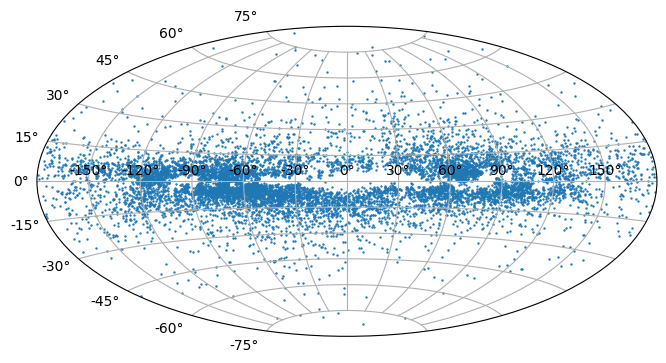

In [6]:
gal = SkyCoord(l, b, frame='galactic', unit=u.deg)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='aitoff')
ax.grid(True)
ax.scatter(gal.l.wrap_at('180d').radian, gal.b.radian,s=0.5)

(array([  1.,   1.,   4.,   2.,   4.,  10.,  12.,   9.,  12.,  15.,  22.,
         21.,  24.,  21.,  23.,  28.,  18.,  23.,  27.,  24.,  22.,  21.,
         25.,  31.,  15.,  25.,  29.,  24.,  25.,  39.,  52.,  85., 115.,
        177., 230., 294., 367., 369., 389., 363., 413., 408., 395., 393.,
        358., 368., 317., 344., 282., 261., 252., 216., 205., 190., 198.,
        155., 167., 161., 140., 127., 115., 102., 112., 119., 107.,  94.,
         88.,  85.,  80.,  66.,  72.,  47.,  53.,  56.,  43.,  43.,  40.,
         30.,  31.,  34.,  26.,  29.,  29.,  23.,  25.,  11.,  19.,  12.,
         12.,  10.,   9.,   6.,   6.,   5.,   5.,   0.,   2.,   2.,   0.,
          2.]),
 array([-0.04058552, -0.00467287,  0.03123978,  0.06715243,  0.10306507,
         0.13897772,  0.17489037,  0.21080302,  0.24671566,  0.2826283 ,
         0.31854096,  0.35445359,  0.39036626,  0.42627889,  0.46219155,
         0.49810418,  0.53401685,  0.56992948,  0.60584211,  0.64175481,
         0.67766744,  0.71

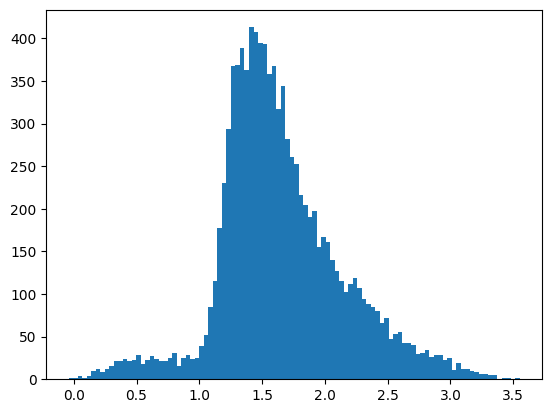

In [7]:
plt.hist(bmr,100)

make a red and blue sample

In [8]:
ind1=np.where(bmr<1.1) #red
ind2=np.where(bmr>2.5) #blue

In [54]:
rands = coord.uniform_spherical_random_surface(size=10000)

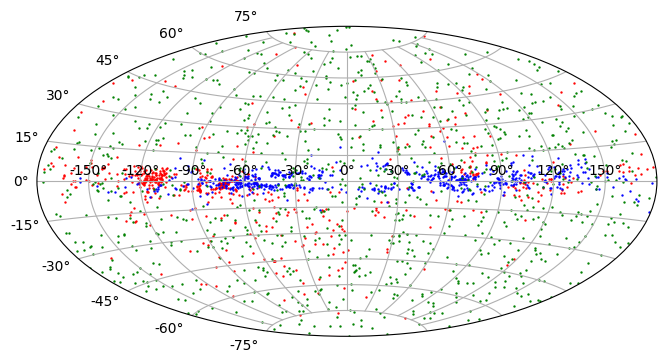

In [11]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='aitoff')
ax.grid(True)
ax.scatter(gal[ind1].l.wrap_at('180d').radian, gal[ind1].b.radian,s=0.5,c='r')
ax.scatter(gal[ind2].l.wrap_at('180d').radian, gal[ind2].b.radian,s=0.5,c='b')
ax.scatter(rands.lon.radian-np.pi, rands.lat.radian,s=0.5,c='g')

In [12]:
pip install treecorr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 21.2 MB/s eta 0:00:00


In [13]:
import treecorr

In [55]:
red = treecorr.Catalog(ra=gal[ind1].l.wrap_at('180d').deg, dec=gal[ind1].b.deg, ra_units='deg', dec_units='deg')
blue = treecorr.Catalog(ra=gal[ind2].l.wrap_at('180d').deg, dec=gal[ind2].b.deg, ra_units='deg', dec_units='deg')
ran = treecorr.Catalog(ra=rands.lon.deg-180., dec=rands.lat.deg, ra_units='deg', dec_units='deg')

In [96]:
nn=treecorr.NNCorrelation(nbins=20, min_sep=0.01, max_sep=10.,sep_units='degrees')
rr=treecorr.NNCorrelation(nbins=20, min_sep=0.01, max_sep=10.,sep_units='degrees')

In [97]:
nn.process(cat1=red,cat2=blue)

In [98]:
rr.process(cat1=red,cat2=ran)

In [99]:
xi=nn.calculateXi(rr=rr)

In [100]:
nn1=treecorr.NNCorrelation(nbins=20, min_sep=0.01, max_sep=10.,sep_units='degrees')
rr1=treecorr.NNCorrelation(nbins=20, min_sep=0.01, max_sep=10.,sep_units='degrees')

nn1.process(cat1=red)
rr1.process(cat1=ran)

In [101]:
xi1=nn1.calculateXi(rr=rr1)

In [102]:
nn2=treecorr.NNCorrelation(nbins=20, min_sep=0.01, max_sep=10.,sep_units='degrees')
rr2=treecorr.NNCorrelation(nbins=20, min_sep=0.01, max_sep=10.,sep_units='degrees')

nn2.process(cat1=blue)
rr2.process(cat1=ran)
xi2=nn2.calculateXi(rr=rr2)

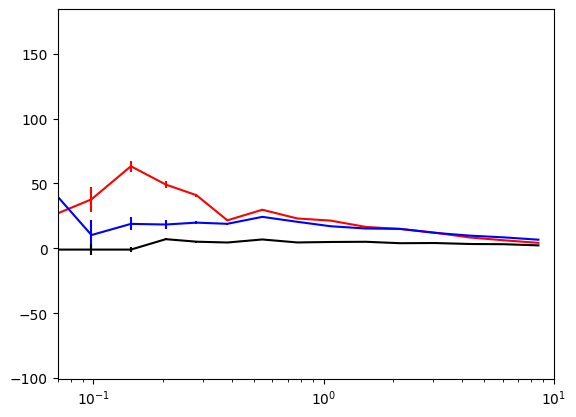

In [105]:
plt.errorbar(nn2.meanr,xi1[0],yerr=xi1[1],c='r')
plt.errorbar(nn2.meanr,xi2[0],yerr=xi2[1],c='b')
plt.errorbar(nn2.meanr,xi[0],yerr=xi[1],c='k')
plt.xlim((7E-2,10))
plt.xlabel(r'$\theta$ [deg]')
plt.ylabel(r'$\xi(\theta)$')
plt.xscale('log')